## Following online [example](https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb)

In [19]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [20]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [21]:
# ENGLISH_STOP_WORDS

#### tokenize, remove stop words

In [22]:
words = []

for text in corpus:
    words2append = [
        token
        for token in text.split() if token not in ENGLISH_STOP_WORDS
    ]
    words.extend(words2append)
words = set(words)

In [23]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

#### find the neighbors

In [24]:
import pandas as pd

windowSize=2

keyValuePairs = []

for text in corpus:
    words2search = [
        token
        for token in text.split() if token not in ENGLISH_STOP_WORDS
    ]
    
    for idx,word in enumerate(words2search):
        for neighbor in words2search[
            max(idx-windowSize,0):
            min(idx+windowSize,len(words2search))
        ]:
            if neighbor!=word:
                keyValuePairs.append({
                    'focus':word,
                    'context':neighbor
                })
df = pd.DataFrame(keyValuePairs)           

In [25]:
df

,context,focus
0,strong,king
1,king,strong
2,man,strong
3,king,man
4,strong,man
5,wise,queen
6,queen,wise
7,woman,wise
8,queen,woman
9,wise,woman


In [26]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

#### encode words

In [27]:
wordEncode = {}
for idx,word in enumerate(words):
    wordEncode[word]=idx

In [28]:
wordEncode

{'boy': 0,
 'young': 1,
 'girl': 2,
 'prince': 3,
 'princess': 4,
 'pretty': 5,
 'man': 6,
 'queen': 7,
 'strong': 8,
 'king': 9,
 'woman': 10,
 'wise': 11}

#### Define Tensorflow graph

In [29]:
import tensorflow as tf
import numpy as np

In [38]:
ONE_HOT_DIM = len(words)
ONE_HOT_DIM

12

In [31]:
#### one hot encoding

def oneHotEncoding(dataIndex):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[dataIndex] = 1
    return one_hot_encoding

In [32]:
x = oneHotEncoding(5)
x
# x.shape

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [33]:
X = [] # input word
Y = [] # target word

for x,y in zip(df.focus,df.context): ## focus-->context
    X.append(oneHotEncoding(wordEncode[x]))
    Y.append(oneHotEncoding(wordEncode[y]))

## convert to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [36]:
# Y_train

In [37]:
X_train.shape, Y_train.shape

((44, 12), (44, 12))

In [39]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [46]:
## making placeholder for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1]))
hidden_layer = tf.add(tf.matmul(x,W1),b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))

check = tf.add(
    tf.matmul(hidden_layer, W2), b2
)

prediction = tf.nn.softmax(check)

# loss function: cross entropy
loss = tf.reduce_mean(
    -tf.reduce_sum(y_label * tf.log(prediction), axis=[1])
)

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

In [47]:
## train the model
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.0206645
iteration 3000 loss is :  1.6838549
iteration 6000 loss is :  1.5997307
iteration 9000 loss is :  1.5775281
iteration 12000 loss is :  1.5670524
iteration 15000 loss is :  1.560408
iteration 18000 loss is :  1.5555046


In [48]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1)
print(vectors)

[[ 1.2239183   1.8367101 ]
 [ 0.3336607   0.17713578]
 [-2.779653    0.9696338 ]
 [ 0.98363674  3.963812  ]
 [-2.5381181   2.3453398 ]
 [ 0.50682706 -2.6945343 ]
 [ 1.4489906   2.3674033 ]
 [-4.5067954   1.8905901 ]
 [ 3.298728   -1.7508254 ]
 [ 2.4788895   4.9800406 ]
 [-0.7965876   0.56147957]
 [-0.75020087 -1.9211046 ]]


In [52]:
# vectors2 = sess.run(W2)
# print(vectors2.T)

In [53]:
## word vector in table
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,boy,1.223918,1.836710
1,young,0.333661,0.177136
2,girl,-2.779653,0.969634
3,prince,0.983637,3.963812
4,princess,-2.538118,2.345340
5,pretty,0.506827,-2.694534
6,man,1.448991,2.367403
7,queen,-4.506795,1.890590
8,strong,3.298728,-1.750825
9,king,2.478889,4.980041


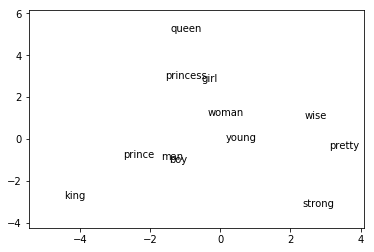

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()
